In [1]:
""" Calculate the rate at which streamflow carries away cations from 
Hubbard Brook watershed 1 """
import xarray as xr
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from shared_read_HBR import *

<AxesSubplot:xlabel='Date'>

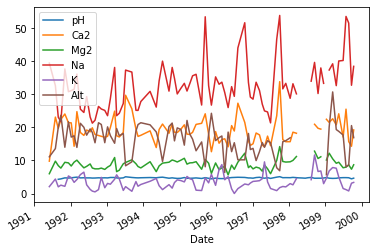

In [2]:
data = read_streamChem()
data.plot()

In [3]:
data.mean()

pH      4.741187
Ca2    19.091124
Mg2     8.838547
Na     32.559828
K       3.598750
Alt    16.287187
dtype: float64

Text(0, 0.5, 'g/m2/s')

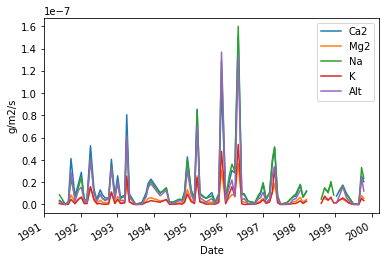

In [4]:
export_rates = convert_streamChem(data)
export_rates.plot()
plt.ylabel('g/m2/s')

In [5]:
export_rates.mean()

Ca2    1.649849e-08
Mg2    4.670567e-09
Na     1.605057e-08
K      4.570811e-09
Alt    1.268390e-08
dtype: float64